In [131]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import matplotlib.patches as mpatches
import json
from scipy.stats import pearsonr
import matplotlib

from plot_utils import *

In [132]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [133]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        if folder == "../results/logprobs" and "continuation" in results.columns:
            #hacky filter out continuation log prob results that were incorrectly saved to the same folder
            continue
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        all_data.append(results)
    df = pd.concat(all_data)

    return df

In [134]:
# Read results for all tasks.
RESULT_DIR = "../results/logprobs"
sent_df = read_data(f"{RESULT_DIR}")
sent_df = sent_df[sent_df.corpus == "SocialN400"]
sent_df = sent_df[sent_df.model.isin(PRETTYNAMES.keys())]
sent_df = sent_df.dropna(axis=1, how='all')
sent_df = sent_df.loc[sent_df.seed != 0] # subset, all the same for 0 and 1
sent_df.head()

,item_id,model,seed,eval_type,data_file,timestamp,corpus,condition,context,sentence,logprob_of_sentence,logprob_of_sentence_in_context,num_tokens_sentence
0,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Control,I went to a mechanic to fix my car.,My car has big wheels now.,-75.828419,-55.208916,10.0
1,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,SemAnom,I decided to paint my boat.,My boat has big wheels now.,-80.191689,-58.234005,10.0
2,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Critical,I decided to turn my boat into a car.,My boat has big wheels now.,-80.191689,-50.705345,10.0
3,2.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Control,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.,-80.793686,-48.885917,15.0
4,2.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,SemAnom,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.,-84.638226,-62.357340,14.0


In [135]:
def get_metrics_df(df):
    """
    Evaluation scheme:
    
    General plausibility
    > P(The bird had a little beak.) > P(The girl had a little beak.)

    Context-dependent plausibility
    > P(The girl had a little beak. | The girl dressed up as a canary for Halloween.)  > P(The girl had a little beak.)

    Sensitivity
    > P(The girl had a little beak. | The girl dressed up as a canary for Halloween.) >
      P(The girl had a little beak. | Anna was definitely a very cute child.)
    """

    frames = []
    for item_id in df.item_id.unique():
        sub_df = df[df.item_id == item_id]
        
        for model in sub_df.model.unique():
            sub_dict = {}
            
            model_df = sub_df[sub_df.model == model]
            control_df = model_df[model_df.condition == "Control"]
            sem_anom_df = model_df[model_df.condition == "SemAnom"]
            critical_df = model_df[model_df.condition == "Critical"]

            sub_dict["item_id"] = item_id
            sub_dict["model"] = model

            sub_dict["General\nPlausibility"] = 1 if control_df.logprob_of_sentence.item() > critical_df.logprob_of_sentence.item() else 0
            sub_dict["Context-Dependent\nPlausibility"] = 1 if critical_df.logprob_of_sentence_in_context.item() > \
                critical_df.logprob_of_sentence.item() else 0
            sub_dict["Context\nSensitivity"] = 1 if critical_df.logprob_of_sentence_in_context.item() \
                                                    > sem_anom_df.logprob_of_sentence_in_context.item() else 0         
            
            sub_dict_df = pd.DataFrame([sub_dict])
            frames.append(sub_dict_df)

    metrics_df = pd.concat(frames, ignore_index=True)
    return metrics_df


In [136]:
sentence_metrics_df = get_metrics_df(sent_df)

# Sort
sentence_metrics_df.model = pd.Categorical(sentence_metrics_df.model, 
                      categories=list(PRETTYNAMES.keys())[1:],
                      ordered=True)
# Summarize
sentence_metrics_summary = sentence_metrics_df.groupby("model").mean().reset_index()
sentence_metrics_summary = sentence_metrics_summary.drop(columns=["item_id"])
sentence_metrics_summary.to_csv("sentence_metrics_df.csv", index=False)
sentence_metrics_summary

,model,General\nPlausibility,Context-Dependent\nPlausibility,Context\nSensitivity
0,Mistral-7B-v0.1,0.93,1.00,0.79
1,Mistral-7B-Instruct-v0.1,0.90,1.00,0.84
2,falcon-7b,0.94,0.92,0.79
3,falcon-7b-instruct,0.91,0.95,0.77
4,mpt-7b,0.93,1.00,0.76
5,mpt-7b-instruct,0.93,1.00,0.80
6,gpt2-xl,0.85,1.00,0.64


# Read human data

`NOTE: File name mismatch with what is reported in the paper! Behavioral should be Sensibility & vice versa, see their Table 4`

In [142]:
import os
behavioral_df = pd.read_csv(os.path.abspath('../datasets/context_plus_sentence/SocialN400/BehavioralData/SocialN400_V1_Behavioral.csv'))
behavioral_df.head()

,SubjID,Subj,List,Run,Confederate,Question,TrialNum,Onset,Condition,Tag,ItemNum,Response,RT
0,EEG_03032016a,1,1,1,1,1,20,250.855165,SemAnom,2,2,0,1.438787
1,EEG_03032016a,1,1,1,1,1,41,519.937655,SemAnom,2,6,1,0.916004
2,EEG_03032016a,1,1,1,1,1,51,654.849517,SemAnom,2,10,0,0.900285
3,EEG_03032016a,1,1,1,1,1,28,352.859678,SemAnom,2,14,1,0.481169
4,EEG_03032016a,1,1,1,1,1,34,428.133590,SemAnom,2,18,0,0.891071


In [143]:
#Tried to do both List and ItemNum first, but ItemNum is already unique & deterministic
behavioral_df = behavioral_df[['Subj', 'ItemNum', 'Condition', 'Confederate', 'Response', 'RT']]
behavioral_df.head()

,Subj,ItemNum,Condition,Confederate,Response,RT
0,1,2,SemAnom,1,0,1.438787
1,1,6,SemAnom,1,1,0.916004
2,1,10,SemAnom,1,0,0.900285
3,1,14,SemAnom,1,1,0.481169
4,1,18,SemAnom,1,0,0.891071


In [144]:
grouped_behavioral_df = behavioral_df.groupby(['Condition', 'Confederate'])['Response', 'RT'].mean().reset_index()
grouped_behavioral_df

/tmp/ipykernel_3195889/1176455832.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_behavioral_df = behavioral_df.groupby(['Condition', 'Confederate'])['Response', 'RT'].mean().reset_index()


,Condition,Confederate,Response,RT
0,Control,0,0.954545,0.766459
1,Control,1,0.941818,0.735048
2,Critical,0,0.863636,0.802318
3,Critical,1,0.280000,0.860292
4,SemAnom,0,0.221818,0.937596
5,SemAnom,1,0.223636,0.897971


In [147]:
annotated_stim = pd.read_csv(os.path.abspath('../datasets/context_plus_sentence/SocialN400/BehavioralData/SocialN400_stimuli_annotated.csv'))
annotated_stim = annotated_stim.dropna()
#Tried to do both List and ItemNum first, but ItemNum is already unique & deterministic
annotated_stim = annotated_stim[['ID', 'ItemNum', 'Sentence1', 'Sentence2']]
annotated_stim.head()

,ID,ItemNum,Sentence1,Sentence2
0,1.0,1.0,I went to a mechanic to fix my car.,My car has big wheels now.
1,2.0,1.0,I decided to paint my boat.,My boat has big wheels now.
2,3.0,1.0,I decided to turn my boat into a car.,My boat has big wheels now.
3,4.0,2.0,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.
4,5.0,2.0,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.


In [148]:
human_merged = behavioral_df.merge(annotated_stim, on = ['ItemNum'])
human_merged.head()

,Subj,ItemNum,Condition,Confederate,Response,RT,ID,Sentence1,Sentence2
0,1,2,SemAnom,1,0,1.438787,4.0,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.
1,1,2,SemAnom,1,0,1.438787,5.0,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.
2,1,2,SemAnom,1,0,1.438787,6.0,Jane was making a baked brie.,Jane put the cheese in the oven for one hour.
3,2,2,Critical,1,1,1.164381,4.0,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.
4,2,2,Critical,1,1,1.164381,5.0,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.


# Do the same for models

In [149]:
def read_data(folder):

    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        all_data.append(results)
    df = pd.concat(all_data)
    return df

In [150]:
# Read results for all tasks.
RESULT_DIR = f"../results/2023_results_prompting/sentence_judge"
df = read_data(f"{RESULT_DIR}")
df = df[df.corpus == "SocialN400"]
df = df.dropna(axis=1, how='all')

,item_id,model,seed,eval_type,data_file,timestamp,corpus,condition,prompt_yes,context,sentence,continuation,logprob_of_yes_sentence,logprob_of_no_sentence,logprob_of_yes_context_and_sentence,logprob_of_no_context_and_sentence
0,1.0,Mistral-7B-Instruct-v0.1,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-07 16:34:38,SocialN400,Control,Here is a sentence:\n\nMy car has big wheels n...,I went to a mechanic to fix my car.,My car has big wheels now.,wheels,-0.317820,-1.364841,-0.437459,-1.074712
1,1.0,Mistral-7B-Instruct-v0.1,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-07 16:34:38,SocialN400,SemAnom,Here is a sentence:\n\nMy boat has big wheels ...,I decided to paint my boat.,My boat has big wheels now.,wheels,-0.808867,-0.628476,-1.168347,-0.399763
2,1.0,Mistral-7B-Instruct-v0.1,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-07 16:34:38,SocialN400,Critical,Here is a sentence:\n\nMy boat has big wheels ...,I decided to turn my boat into a car.,My boat has big wheels now.,wheels,-0.808867,-0.628476,-3.327538,-0.056362
3,2.0,Mistral-7B-Instruct-v0.1,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-07 16:34:38,SocialN400,Control,Here is a sentence:\n\nJane put the turkey in ...,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.,oven,-0.190976,-1.827537,-0.244042,-1.594030
4,2.0,Mistral-7B-Instruct-v0.1,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-07 16:34:38,SocialN400,SemAnom,Here is a sentence:\n\nJane put the cheese in ...,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.,oven,-0.192953,-1.825989,-0.951765,-0.521738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,99.0,mpt-7b,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2023-12-09 22:24:51,SocialN400,SemAnom,Here is a sentence:\n\nIt is often cold and sn...,The Smiths decided to spend their Christmas in...,It is often cold and snowing in summer there.,summer,-1.928219,-1.211838,-1.865237,-1.302806
296,99.0,mpt-7b,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2023-12-09 22:24:51,SocialN400,Critical,Here is a sentence:\n\nIt is often cold and sn...,"In Australia, winter is the warmest out of the...",It is often cold and snowing in summer there.,summer,-1.928219,-1.211838,-1.818874,-1.534519
297,100.0,mpt-7b,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2023-12-09 22:24:51,SocialN400,Control,Here is a sentence:\n\nThe crown is made of go...,Henry VIII's crown can be seen at the British ...,The crown is made of gold and decorated with d...,gold,-1.491023,-1.495540,-1.519163,-1.441221
298,100.0,mpt-7b,0,metaQuestionComplex,/net/vast-storage.ib.cluster/scratch/vast/evla...,2023-12-09 22:24:51,SocialN400,SemAnom,Here is a sentence:\n\nThe shoes are made of g...,Mary purchased her baby boy's first shoes.,The shoes are made of gold and decorated with ...,gold,-1.580011,-1.381219,-1.599158,-1.393798


In [151]:
df = df[["item_id", "model", "eval_type", "condition", "logprob_of_yes_sentence", "logprob_of_no_sentence",
        "logprob_of_yes_context_and_sentence", "logprob_of_no_context_and_sentence"]]
df

,item_id,model,eval_type,condition,logprob_of_yes_sentence,logprob_of_no_sentence,logprob_of_yes_context_and_sentence,logprob_of_no_context_and_sentence
0,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,-0.317820,-1.364841,-0.437459,-1.074712
1,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,-0.808867,-0.628476,-1.168347,-0.399763
2,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Critical,-0.808867,-0.628476,-3.327538,-0.056362
3,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,-0.190976,-1.827537,-0.244042,-1.594030
4,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,-0.192953,-1.825989,-0.951765,-0.521738
...,...,...,...,...,...,...,...,...
295,99.0,mpt-7b,metaQuestionComplex,SemAnom,-1.928219,-1.211838,-1.865237,-1.302806
296,99.0,mpt-7b,metaQuestionComplex,Critical,-1.928219,-1.211838,-1.818874,-1.534519
297,100.0,mpt-7b,metaQuestionComplex,Control,-1.491023,-1.495540,-1.519163,-1.441221
298,100.0,mpt-7b,metaQuestionComplex,SemAnom,-1.580011,-1.381219,-1.599158,-1.393798


In [152]:
def get_accuracy_df(df):
    out_df = df.copy()
    # True positive
    out_df["model_prefers_yes_in_sent"] = out_df.apply(
        lambda row: 1 if row.logprob_of_yes_sentence > row.logprob_of_no_sentence else 0, axis=1)
    out_df["model_prefers_yes_in_cont_and_sent"] = out_df.apply(
        lambda row: 1 if row.logprob_of_yes_context_and_sentence > row.logprob_of_no_context_and_sentence else 0, axis=1)
    return out_df

out_df = get_accuracy_df(df)
out_df = out_df.loc[:, ~out_df.columns.str.startswith('logprob')]
out_df

,item_id,model,eval_type,condition,model_prefers_yes_in_sent,model_prefers_yes_in_cont_and_sent
0,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,1,1
1,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,0,0
2,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Critical,0,0
3,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,1,1
4,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,1,0
...,...,...,...,...,...,...
295,99.0,mpt-7b,metaQuestionComplex,SemAnom,0,0
296,99.0,mpt-7b,metaQuestionComplex,Critical,0,0
297,100.0,mpt-7b,metaQuestionComplex,Control,1,0
298,100.0,mpt-7b,metaQuestionComplex,SemAnom,0,0


In [153]:
df_restructured = out_df.melt(id_vars=['item_id', 'model', 'eval_type', 'condition'],
                          value_vars=['model_prefers_yes_in_sent', 'model_prefers_yes_in_cont_and_sent'],
                          var_name='confederate_type', value_name='accuracy')
df_restructured

,item_id,model,eval_type,condition,confederate_type,accuracy
0,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,model_prefers_yes_in_sent,1
1,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,model_prefers_yes_in_sent,0
2,1.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Critical,model_prefers_yes_in_sent,0
3,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,Control,model_prefers_yes_in_sent,1
4,2.0,Mistral-7B-Instruct-v0.1,metaQuestionComplex,SemAnom,model_prefers_yes_in_sent,1
...,...,...,...,...,...,...
11995,99.0,mpt-7b,metaQuestionComplex,SemAnom,model_prefers_yes_in_cont_and_sent,0
11996,99.0,mpt-7b,metaQuestionComplex,Critical,model_prefers_yes_in_cont_and_sent,0
11997,100.0,mpt-7b,metaQuestionComplex,Control,model_prefers_yes_in_cont_and_sent,0
11998,100.0,mpt-7b,metaQuestionComplex,SemAnom,model_prefers_yes_in_cont_and_sent,0


In [154]:
df_restructured["Confederate"] = df_restructured["confederate_type"].apply(lambda x: 1 if x == "model_prefers_yes_in_sent" else 0)
df_restructured = df_restructured.rename(columns = {"item_id" : "ItemNum", "accuracy" : "Response", "condition" : "Condition"})
df_restructured = df_restructured.drop(columns=["eval_type", "confederate_type"])
df_restructured = df_restructured[["ItemNum", "Condition", "Confederate", "Response", "model"]]
df_restructured

,ItemNum,Condition,Confederate,Response,model
0,1.0,Control,1,1,Mistral-7B-Instruct-v0.1
1,1.0,SemAnom,1,0,Mistral-7B-Instruct-v0.1
2,1.0,Critical,1,0,Mistral-7B-Instruct-v0.1
3,2.0,Control,1,1,Mistral-7B-Instruct-v0.1
4,2.0,SemAnom,1,1,Mistral-7B-Instruct-v0.1
...,...,...,...,...,...
11995,99.0,SemAnom,0,0,mpt-7b
11996,99.0,Critical,0,0,mpt-7b
11997,100.0,Control,0,0,mpt-7b
11998,100.0,SemAnom,0,0,mpt-7b


In [155]:
behavioral_df = behavioral_df.groupby(['ItemNum', 'Condition', 'Confederate'])['Response'].mean().reset_index()
behavioral_df["model"] = "human"
behavioral_df

,ItemNum,Condition,Confederate,Response,model
0,1,Control,0,0.600000,human
1,1,Control,1,1.000000,human
2,1,Critical,0,0.833333,human
3,1,Critical,1,0.000000,human
4,1,SemAnom,0,0.000000,human
...,...,...,...,...,...
595,100,Control,1,1.000000,human
596,100,Critical,0,1.000000,human
597,100,Critical,1,0.666667,human
598,100,SemAnom,0,0.500000,human


In [156]:
plot_df = pd.concat([behavioral_df, df_restructured])
plot_df = plot_df.drop_duplicates()
plot_df.to_csv('ContextDependency.SocialN400.SentenceJudgeComparison.ByModel.csv', index=False)

,ItemNum,Condition,Confederate,Response,model
0,1.0,Control,0,0.600000,human
1,1.0,Control,1,1.000000,human
2,1.0,Critical,0,0.833333,human
3,1.0,Critical,1,0.000000,human
4,1.0,SemAnom,0,0.000000,human
...,...,...,...,...,...
11395,99.0,SemAnom,0,0.000000,mpt-7b
11396,99.0,Critical,0,0.000000,mpt-7b
11397,100.0,Control,0,0.000000,mpt-7b
11398,100.0,SemAnom,0,0.000000,mpt-7b


In [157]:
stats_df = plot_df.groupby(["model", "Confederate", "Condition"])["Response"].mean().reset_index()
stats_df

,model,Confederate,Condition,Response
0,Mistral-7B-Instruct-v0.1,0,Control,0.930000
1,Mistral-7B-Instruct-v0.1,0,Critical,0.660000
2,Mistral-7B-Instruct-v0.1,0,SemAnom,0.460000
3,Mistral-7B-Instruct-v0.1,1,Control,0.950000
4,Mistral-7B-Instruct-v0.1,1,Critical,0.440000
5,Mistral-7B-Instruct-v0.1,1,SemAnom,0.440000
6,Mistral-7B-v0.1,0,Control,0.920000
7,Mistral-7B-v0.1,0,Critical,0.820000
8,Mistral-7B-v0.1,0,SemAnom,0.790000
9,Mistral-7B-v0.1,1,Control,0.990000


/tmp/ipykernel_3195889/533887769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Confederate'] = plot_df['Confederate'].map({0: 'Context', 1: 'No context'})


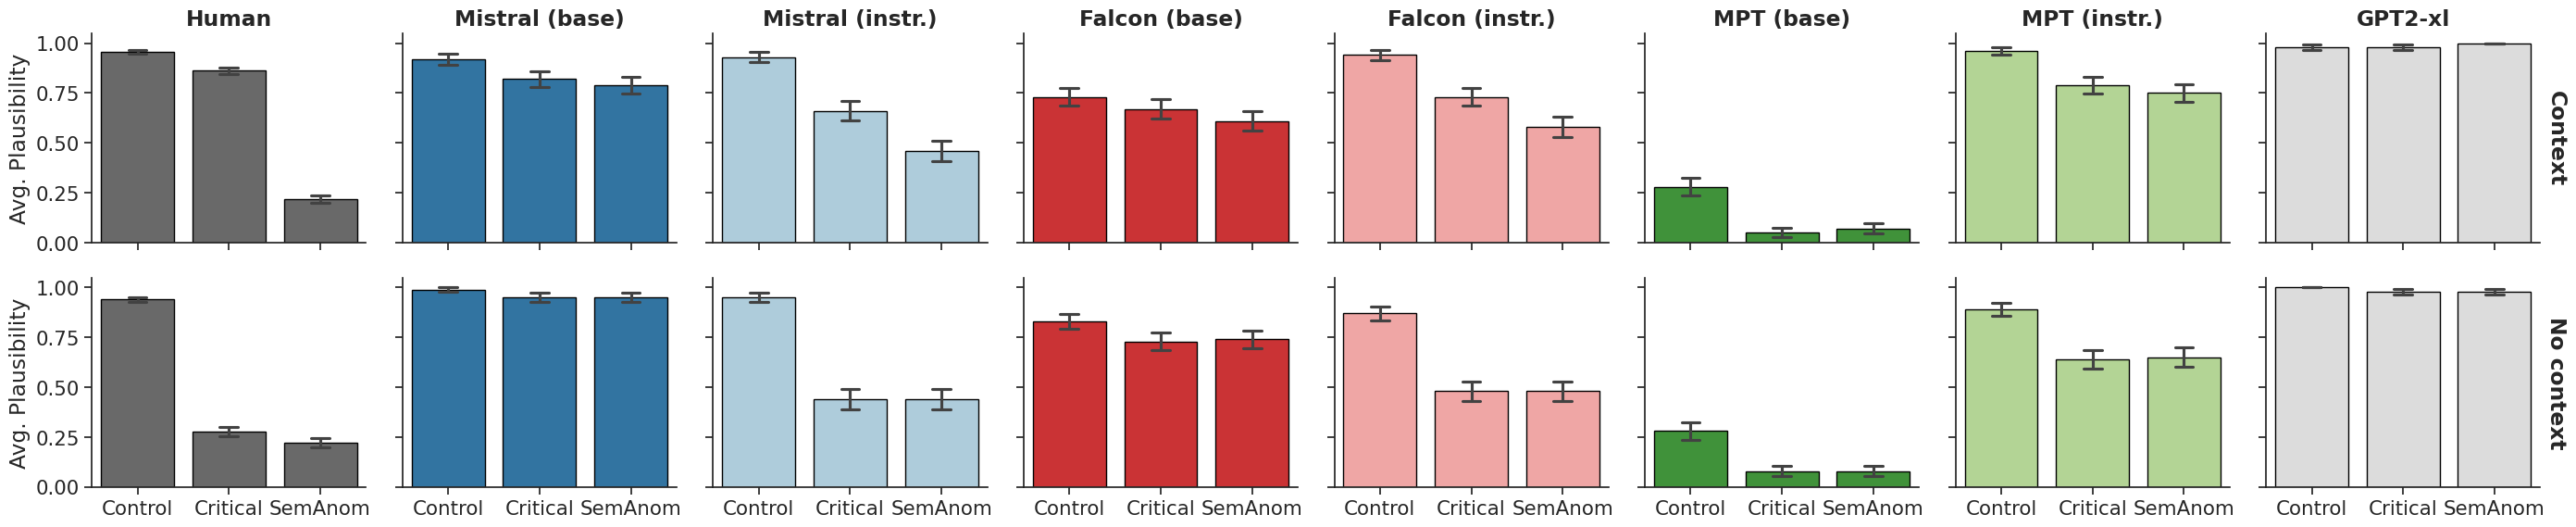

In [158]:
PLOT_MODEL_PAL = MODEL_PAL.copy()
PLOT_MODEL_PAL["human"] = "dimgray"
col_order = [m for m in list(PRETTYNAMES.keys())]
plot_df = plot_df.loc[plot_df.model.isin(PRETTYNAMES.keys())]
plot_df['Confederate'] = plot_df['Confederate'].map({0: 'Context', 1: 'No context'})

# Calculate the new aspect ratio based on the original aspect and height change
original_height = 3.5
new_height = 3
original_aspect = 1
new_aspect = original_aspect * (original_height / new_height)

g = sns.FacetGrid(plot_df, col="model", row="Confederate", hue="model", margin_titles=True, height=new_height, aspect=new_aspect,
                  palette=PLOT_MODEL_PAL, col_order=col_order)

def plot_func(x, y, **kwargs):
    sns.barplot(x=x, y=y, edgecolor='black', errorbar='se', capsize=0.2, **kwargs)

g.map_dataframe(plot_func, x="Condition", y="Response")

# Setting custom titles for rows
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontweight='bold')

for subx in g.axes.flatten():       
    if subx.get_title() != "":
        subx.set_title(PRETTYNAMES[subx.get_title().split(" = ")[-1]], fontweight='bold')
        subx_xticklabels = subx.get_xticklabels()
        if subx_xticklabels:
            subx.set_xticklabels([PRETTYNAMES.get(label.get_text(), label.get_text()) for label in subx_xticklabels])


# Add labels and legend
g.set_axis_labels("", "Avg. Plausibility")

g.tight_layout()

plt.savefig('figures/ContextDependency.SocialN400.SentenceJudgeComparison.ByModel.png', dpi=280, bbox_inches="tight")

# Show the plot
plt.show()

# Look at log probability of just the critical word

In [116]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        all_data.append(results)
    df = pd.concat(all_data)

    return df

In [117]:
# Read results for all tasks.
RESULT_DIR = f"../results/logprobs_critical_word"
cw_df = read_data(f"{RESULT_DIR}")
cw_df.head()

,item_id,condition,context,prefix,continuation,logprob_of_cont_in_sent,logprob_of_cond_in_sent_in_context,model,seed,data_file,timestamp,corpus
0,1.0,Control,I went to a mechanic to fix my car.,My car has big,wheels,-1.880592,-1.981365,Mistral-7B-Instruct-v0.1,0,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-08 04:53:19,SocialN400
1,1.0,SemAnom,I decided to paint my boat.,My boat has big,wheels,-3.347833,-5.402104,Mistral-7B-Instruct-v0.1,0,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-08 04:53:19,SocialN400
2,1.0,Critical,I decided to turn my boat into a car.,My boat has big,wheels,-3.347833,-0.760486,Mistral-7B-Instruct-v0.1,0,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-08 04:53:19,SocialN400
3,2.0,Control,Jane was cooking Christmas dinner.,Jane put the turkey in the,oven,-0.052864,-0.035237,Mistral-7B-Instruct-v0.1,0,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-08 04:53:19,SocialN400
4,2.0,SemAnom,Jane was unpacking the groceries.,Jane put the cheese in the,oven,-2.082855,-7.812779,Mistral-7B-Instruct-v0.1,0,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-08 04:53:19,SocialN400


In [118]:
def get_metrics_df_continuation(df):
    """
    Evaluation scheme:
    
    General plausibility
    > P(beak | The bird had a little ) > P(beak | The girl had a little )
    
    Context-dependent plausibility
    > P(beak | The girl dressed up as a canary for Halloween. The girl had a little )  > P(beak | The girl had a little ) &
      P(beak | Anna was definitely a very cute child. The girl had a little ) <= P(beak | The girl had a little )

    Selectivity
    > P(beak | The girl dressed up as a canary for Halloween. The girl had a little ) >
      P(beak | Anna was definitely a very cute child. The girl had a little )
    """

    frames = []
    for item_id in df.item_id.unique():
        sub_df = df[df.item_id == item_id]
        
        for model in sub_df.model.unique():
            sub_dict = {}
            
            model_df = sub_df[sub_df.model == model]
            control_df = model_df[model_df.condition == "Control"]
            sem_anom_df = model_df[model_df.condition == "SemAnom"]
            critical_df = model_df[model_df.condition == "Critical"]

            sub_dict["item_id"] = item_id
            sub_dict["model"] = model
            sub_dict["General\nPlausibility"] = 1 if (control_df.logprob_of_cont_in_sent.item() > \
                                                 critical_df.logprob_of_cont_in_sent.item()) else 0
            sub_dict["Context-Dependent\nPlausibility"] = 1 if critical_df.logprob_of_cond_in_sent_in_context.item() > \
                                                        critical_df.logprob_of_cont_in_sent.item() \
                                                    else 0

            sub_dict["Context\nSensitivity"] = 1 if critical_df.logprob_of_cond_in_sent_in_context.item() \
                                                    > sem_anom_df.logprob_of_cond_in_sent_in_context.item() else 0
            
            sub_dict_df = pd.DataFrame([sub_dict])
            frames.append(sub_dict_df)

    metrics_df = pd.concat(frames, ignore_index=True)
    return metrics_df


In [119]:
metrics_df = get_metrics_df_continuation(cw_df)
metrics_df

,item_id,model,General\nPlausibility,Context-Dependent\nPlausibility,Context\nSensitivity
0,1.0,Mistral-7B-Instruct-v0.1,1,1,1
1,1.0,Mistral-7B-v0.1,1,1,1
2,1.0,falcon-7b-instruct,1,1,1
3,1.0,falcon-7b,1,1,1
4,1.0,gpt2-xl,1,1,1
...,...,...,...,...,...
695,100.0,falcon-7b-instruct,1,1,1
696,100.0,falcon-7b,1,1,1
697,100.0,gpt2-xl,1,1,1
698,100.0,mpt-7b-instruct,1,1,1


In [120]:
word_metrics_df = get_metrics_df_continuation(cw_df)

# Sort
word_metrics_df.model = pd.Categorical(word_metrics_df.model, 
                      categories=list(PRETTYNAMES.keys())[1:],
                      ordered=True)
# Summarize
word_metrics_summary = word_metrics_df.groupby("model").mean().reset_index()
word_metrics_summary = word_metrics_summary.drop(columns=["item_id"])
word_metrics_summary.to_csv("word_metrics_df.csv", index=False)
word_metrics_summary

,model,General\nPlausibility,Context-Dependent\nPlausibility,Context\nSensitivity
0,Mistral-7B-v0.1,0.90,0.93,0.97
1,Mistral-7B-Instruct-v0.1,0.97,0.93,0.90
2,falcon-7b,0.96,0.93,0.98
3,falcon-7b-instruct,0.98,0.95,0.96
4,mpt-7b,0.96,0.95,0.99
5,mpt-7b-instruct,0.94,0.93,0.95
6,gpt2-xl,0.91,0.88,0.91


In [121]:
# Pivot to long format
df_long = pd.melt(metrics_df, id_vars=['item_id', 'model'], var_name='metric', value_name='Accuracy')
df_long = df_long.loc[df_long.model.isin(PRETTYNAMES.keys())]

In [122]:
stats_df = df_long.groupby(["model", "metric"])["Accuracy"].agg(["mean", "sem"]).reset_index()
stats_df

,model,metric,mean,sem
0,Mistral-7B-Instruct-v0.1,Context\nSensitivity,0.90,0.030151
1,Mistral-7B-Instruct-v0.1,Context-Dependent\nPlausibility,0.93,0.025643
2,Mistral-7B-Instruct-v0.1,General\nPlausibility,0.97,0.017145
3,Mistral-7B-v0.1,Context\nSensitivity,0.97,0.017145
4,Mistral-7B-v0.1,Context-Dependent\nPlausibility,0.93,0.025643
5,Mistral-7B-v0.1,General\nPlausibility,0.90,0.030151
6,falcon-7b,Context\nSensitivity,0.98,0.014071
7,falcon-7b,Context-Dependent\nPlausibility,0.93,0.025643
8,falcon-7b,General\nPlausibility,0.96,0.019695
9,falcon-7b-instruct,Context\nSensitivity,0.96,0.019695


# Recreate Sentence Judge Figure with LogProbs for Critical Words

In [125]:
sent_df

,item_id,model,seed,eval_type,data_file,timestamp,corpus,condition,context,sentence,logprob_of_sentence,logprob_of_sentence_in_context,num_tokens_sentence
0,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Control,I went to a mechanic to fix my car.,My car has big wheels now.,-75.828419,-55.208916,10.0
1,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,SemAnom,I decided to paint my boat.,My boat has big wheels now.,-80.191689,-58.234005,10.0
2,1.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Critical,I decided to turn my boat into a car.,My boat has big wheels now.,-80.191689,-50.705345,10.0
3,2.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,Control,Jane was cooking Christmas dinner.,Jane put the turkey in the oven for one hour.,-80.793686,-48.885917,15.0
4,2.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:55,SocialN400,SemAnom,Jane was unpacking the groceries.,Jane put the cheese in the oven for one hour.,-84.638226,-62.357340,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,99.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:13,SocialN400,SemAnom,The Smiths decided to spend their Christmas in...,It is often cold and snowing in summer there.,-54.001520,-44.847558,13.0
296,99.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:13,SocialN400,Critical,"In Australia, winter is the warmest out of the...",It is often cold and snowing in summer there.,-54.001520,-41.027711,13.0
297,100.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:13,SocialN400,Control,Henry VIII's crown can be seen at the British ...,The crown is made of gold and decorated with d...,-41.487683,-21.471224,13.0
298,100.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:13,SocialN400,SemAnom,Mary purchased her baby boy's first shoes.,The shoes are made of gold and decorated with ...,-47.801943,-27.105901,13.0


In [127]:
def prep_df_for_grouped_barplot(df, ll="word"):
    # Reformat dataframe
    if ll == "sentence":
        context_column = "logprob_of_sentence_in_context"
        single_sent_column = "logprob_of_sentence"
    elif ll == "word":
        context_column = "logprob_of_cond_in_sent_in_context"
        single_sent_column = "logprob_of_cont_in_sent"
    else:
        raise NotImplementedError
        
    df1 = df[['condition', 'model', 'item_id', context_column]].copy()
    df1['context'] = "Context"
    df1.rename(columns={context_column: 'Response'}, inplace=True)
    
    df2 = df[['condition', 'model', 'item_id', single_sent_column]].copy()
    df2['context'] = "No context"
    df2.rename(columns={single_sent_column: 'Response'}, inplace=True)
    
    # Concatenate the two dataframes
    combined_df = pd.concat([df1, df2])

    #### ADD HUMAN DATA
    #behavioral_df_grouped = behavioral_df.drop(columns=["ItemNum"])
    behavioral_df_grouped = behavioral_df
    
    behavioral_df_grouped.rename(columns={"Condition" : "condition", "ItemNum" : "item_id"}, inplace=True)
    behavioral_df_grouped['context'] = behavioral_df_grouped['Confederate'].apply(lambda x: "Context" if x == 0 else "No context")
    behavioral_df_grouped = behavioral_df_grouped.drop(columns={"Confederate"})
    
    # Combine
    plot_df = pd.concat([behavioral_df_grouped, combined_df])

    # Order conditions
    plot_df['condition'] = pd.Categorical(plot_df['condition'], categories=["Control", "Critical", "SemAnom"], ordered=True)
    
    return plot_df

plot_df = prep_df_for_grouped_barplot(cw_df, ll="word")
plot_df

,item_id,condition,Response,model,context
0,1.0,Control,0.600000,human,Context
1,1.0,Control,1.000000,human,No context
2,1.0,Critical,0.833333,human,Context
3,1.0,Critical,0.000000,human,No context
4,1.0,SemAnom,0.000000,human,Context
...,...,...,...,...,...
295,99.0,SemAnom,-8.011397,mpt-7b,No context
296,99.0,Critical,-8.011397,mpt-7b,No context
297,100.0,Control,-3.852189,mpt-7b,No context
298,100.0,SemAnom,-7.096367,mpt-7b,No context


In [128]:
def plot_grouped_plot_socialn400(df, ll, plottype="bar"):
    # Get plot_df
    plot_df = prep_df_for_grouped_barplot(df=df, ll=ll)
    plot_df['condition'] = plot_df['condition'].replace('SemAnom', 'S.Anom')
    plot_df.to_csv(f'ContextDependency.SocialN400.{ll.capitalize()}LLComparison.ByModel.csv', index=False)
    # Calculate the new aspect ratio based on the original aspect and height change
    original_height = 3
    new_height = 3.2
    original_aspect = 1.1
    new_aspect = original_aspect * (original_height / new_height)
    
    g = sns.FacetGrid(plot_df, col="model", row="context", hue="model", margin_titles=True, height=new_height, aspect=new_aspect,
                      palette=PLOT_MODEL_PAL, col_order=col_order, sharey=False)
    
    def plot_func(x, y, **kwargs):
        if plottype == "bar":
            sns.barplot(x=x, y=y, edgecolor='black', errorbar='se', capsize=0.2, **kwargs)
        elif plottype == "violin":
            sns.violinplot(x=x, y=y, **kwargs)
        elif plottype == "pointplot":
            # Add stripplot for individual data points
            sns.stripplot(x=x, y=y, dodge=True, alpha=.1, jitter=True, **kwargs)
            # Add pointplot for summary statistics
            sns.pointplot(x=x, y=y, linestyle="none",
                          marker="_", markersize=30, markeredgewidth=10, **kwargs)
        else:
            raise NotImplementedError
    
    g.map_dataframe(plot_func, x="condition", y="Response")
        
    
    # Setting custom titles for rows
    g.set_titles(row_template="", col_template="{col_name}", fontweight='bold', size=25)
    
    for subx in g.axes.flatten():       
        if subx.get_title() != "":
            subx.set_title(PRETTYNAMES[subx.get_title().split(" = ")[-1]], fontweight='bold', pad=15, fontsize=25)
            subx_xticklabels = subx.get_xticklabels()
            if subx_xticklabels:
                subx.set_xticklabels([PRETTYNAMES.get(label.get_text(), label.get_text()) for label in subx_xticklabels], fontsize=25)

    # Iterate over the axes to place row names to the left of the y-axis
    for ax, row_name in zip(g.axes[:, 0], g.row_names):  # Only the first column of axes and corresponding row names
    
        # Place the row name to the left of the y-axis
        ax.text(-0.4, 0.5, row_name, transform=ax.transAxes, ha="right", va="center", 
                fontsize=25, fontweight='bold', rotation=90)

    # Group and aggregate the DataFrame
    agg_df = plot_df.groupby(["model", "context", "condition"])['Response'].agg(['mean', 'sem']).reset_index()
    min_val_df = agg_df.groupby("model").agg(min_mean=('mean', 'min'), min_sem=('sem', 'mean')).reset_index()
    max_val_df = agg_df.groupby("model").agg(max_mean=('mean', 'max'), max_sem=('sem', 'mean')).reset_index()
    
    # Merge the two DataFrames
    merged = min_val_df.merge(max_val_df, on="model")
    
    min_y_with_sem = {}
    max_val = {}
    
    # Iterate over each row in the merged DataFrame
    for _, row in merged.iterrows():
        model = row['model']
    
        # Assign max_val based on the 'll' value
        if ll == "word":
            max_val[model] = 0
            min_y_with_sem[model] = row['min_mean'] + row['min_sem'] - 1
        elif ll == "sentence":
            max_val[model] = row['max_mean'] + row['max_sem'] + 5
            min_y_with_sem[model] = row['min_mean'] + row['min_sem'] - 10
    
    # Iterate over the axes to set the y-axis limits
    for i, ax in enumerate(g.axes.flatten()):
        if i%8 == 0: # don't do for humans
            continue
        # Find the model (column) that the current ax corresponds to
        model_val = g.col_names[i % len(g.col_names)]
        # Set the y-axis limit for the ax
        ax.set_ylim(min_y_with_sem[model_val], max_val[model])

    
    # Add labels and legend
    g.set_axis_labels("", "Avg. score")
    
    g.tight_layout()

    plt.savefig(f'figures/ContextDependency.SocialN400.{ll.capitalize()}LLComparison.ByModel.{plottype.capitalize()}.png', dpi=280, bbox_inches="tight")
    
    # Show the plot
    plt.show()

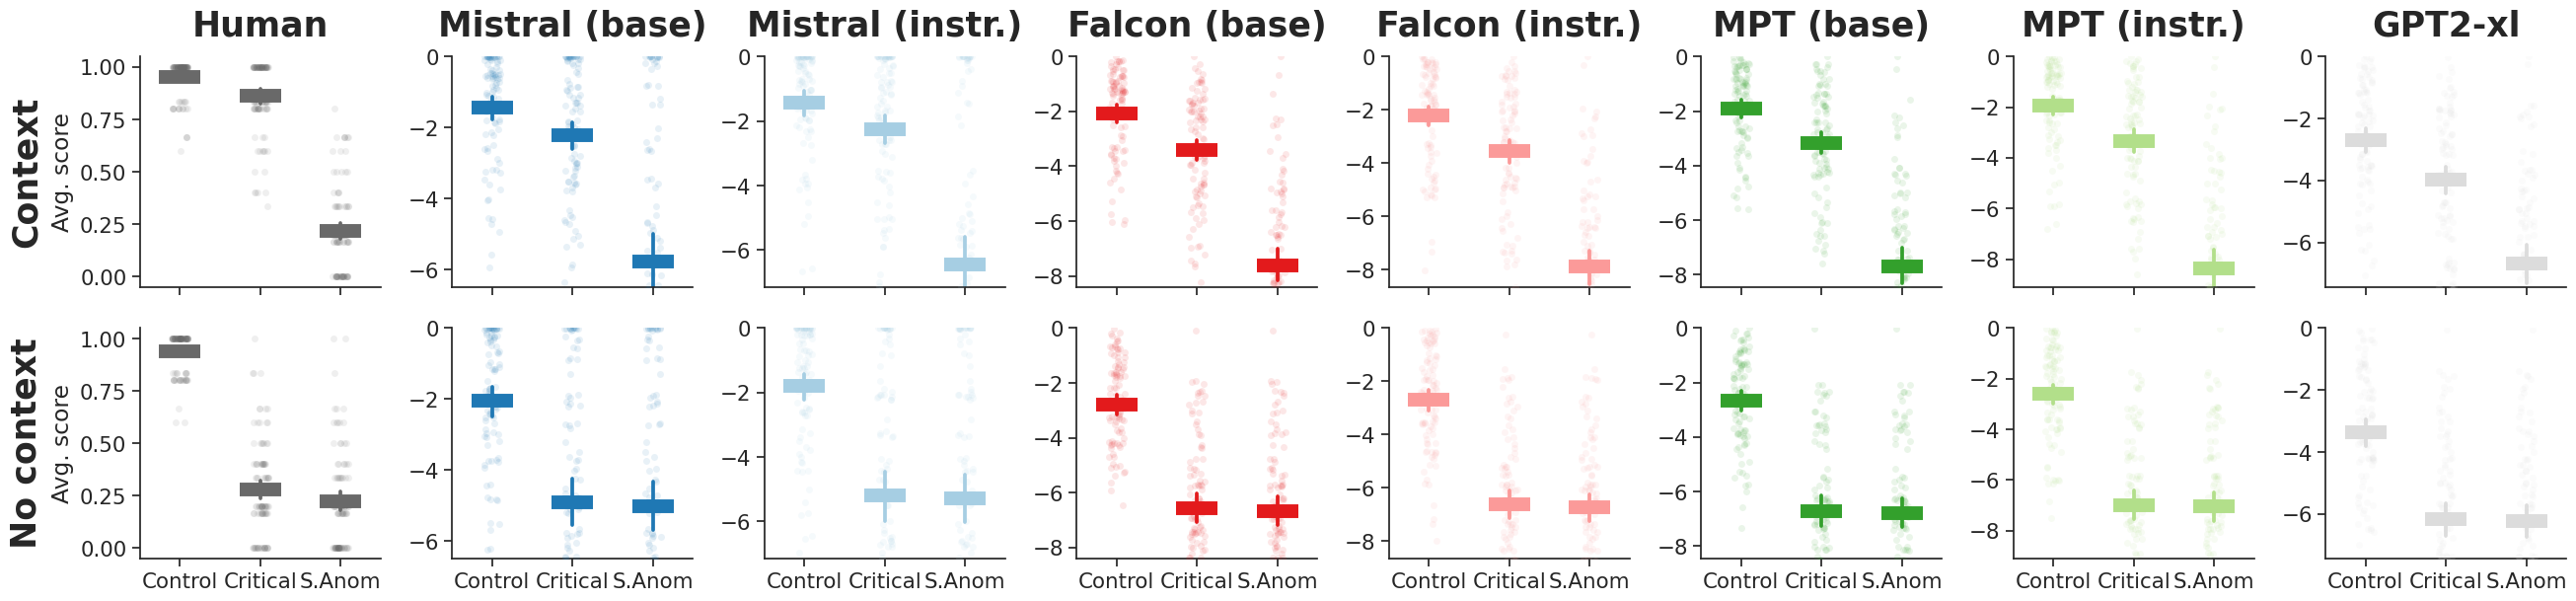

In [129]:
plot_grouped_plot_socialn400(cw_df, ll="word", plottype="pointplot")

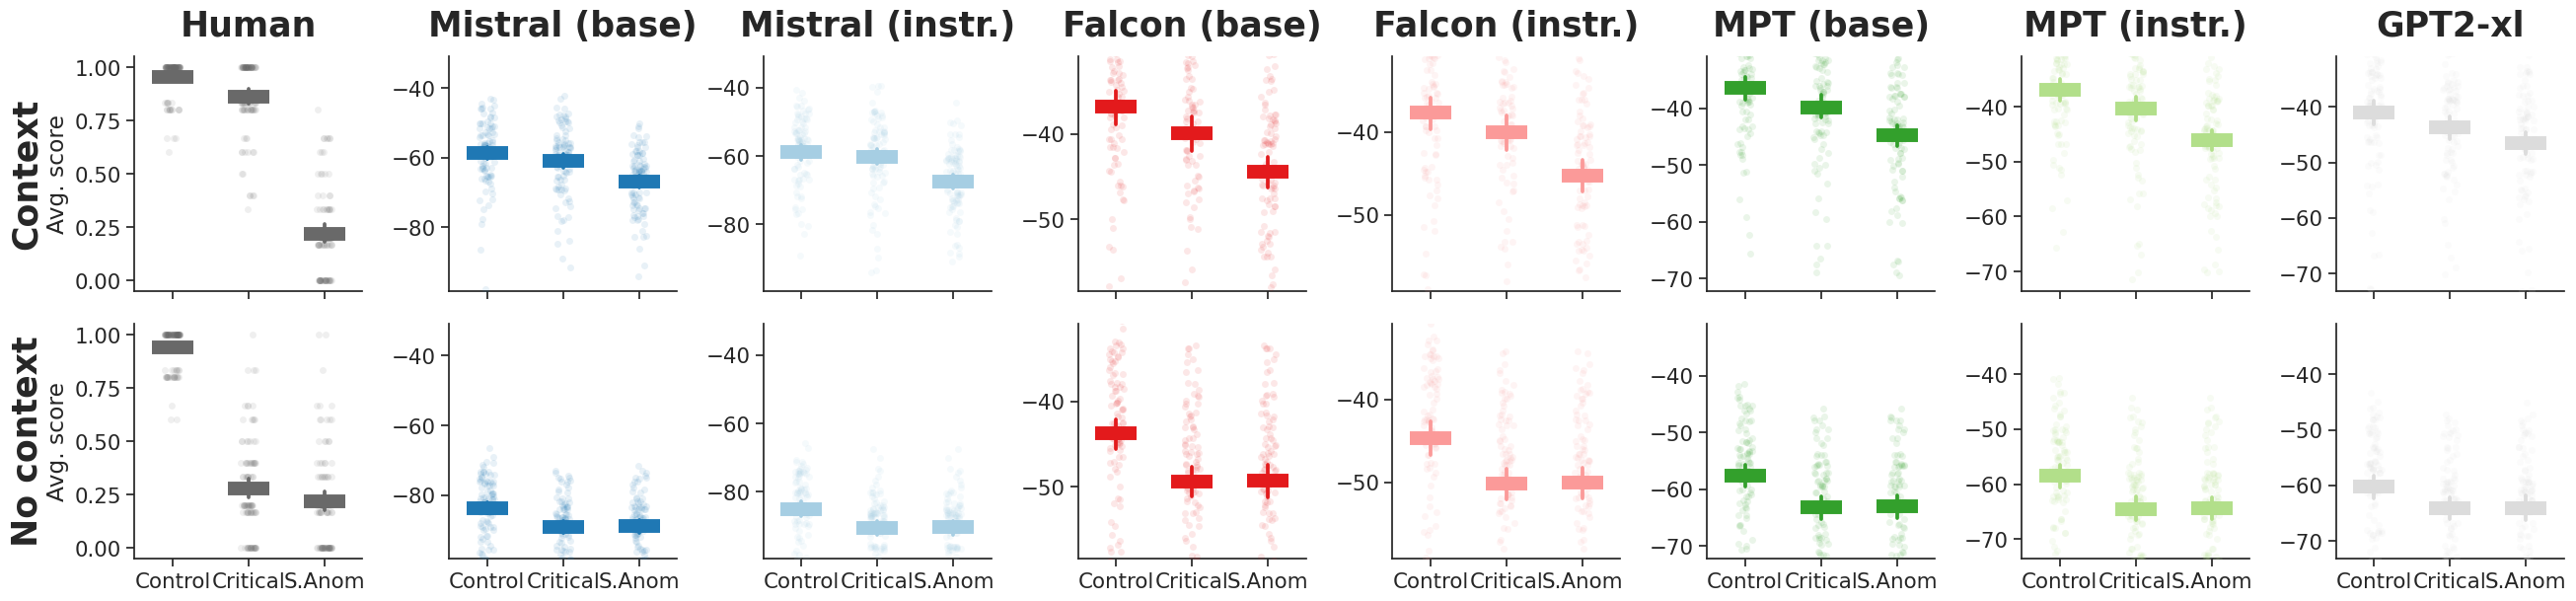

In [130]:
plot_grouped_plot_socialn400(sent_df, ll="sentence", plottype="pointplot")